In [6]:
from datetime import datetime, timedelta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from utils_IO import get_data_in_chunks

In [2]:
# Example usage
start_date = datetime(2022, 1, 1)
end_date = datetime(2024, 1, 1)
chunk_size_days = 7  # 1 week
thing = "UIPA.HMD8310H.Engine1"
engine1  = get_data_in_chunks(thing, start_date, end_date, chunk_size_days)

thing = "UIPA.HMD8310H.Engine2"
engine2 = get_data_in_chunks(thing, start_date, end_date, chunk_size_days)

: 

In [8]:
start_date = datetime(2022, 1, 1)
end_date = datetime(2024, 1, 1)
chunk_size_days = 7  # 1 week
thing = "DE1FlowMeterThing_HMD8310"
flow_meter  = get_data_in_chunks(thing, start_date, end_date, chunk_size_days)

/home/danielkim/Desktop/mna_lab/battery_AD/utils_IO.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat(df_chunks, ignore_index=True)


<Axes: >

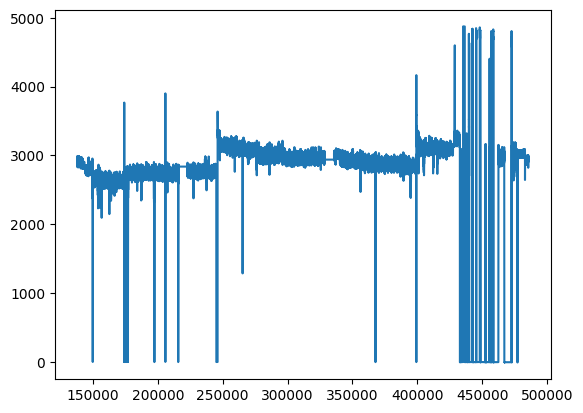

In [18]:
valid_data = flow_meter[["FOVolumeFlowIn", "FOVolumeFlowReturn"]].loc[138080:].copy()
valid_data["FOVolumeFlowReturn"].plot()

In [ ]:
engine1["battery_only"] = engine1["dIECSPoweredByBatteryOnlyPilotTrip"].fillna(0).astype(int)
engine2["battery_only"] = engine2["dIECSPoweredByBatteryOnlyPilotTrip"].fillna(0).astype(int)

/tmp/ipykernel_5664/1752337797.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  engine1["battery_only"] = engine1["dIECSPoweredByBatteryOnlyPilotTrip"].fillna(0).astype(int)
/tmp/ipykernel_5664/1752337797.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  engine2["battery_only"] = engine2["dIECSPoweredByBatteryOnlyPilotTrip"].fillna(0).astype(int)


In [ ]:
merged_df = pd.merge(engine1[["aIEngineLoad", "time", "battery_only"]], engine2[["aIEngineLoad", "time"]], on='time', how='inner')
merged_df["total_load"] = merged_df["aIEngineLoad_x"] + merged_df["aIEngineLoad_y"]
merged_df_all_columns = pd.merge(engine1, engine2, on='time', how='inner')
merged_df_all_columns["total_load"] = merged_df_all_columns["aIEngineLoad_x"] + merged_df_all_columns["aIEngineLoad_y"]

# MGO

In [ ]:
mgo = pd.read_csv("RemoteLevelThing_HMD8310.csv")
mgo["total_vol"] = mgo["MGO_STOR_TK_C_CALC_VOL"] + mgo["MGO_STOR_TK_S_CALC_VOL"] + mgo["NO1_MGO_SERV_TK_CALC_VOL"] + mgo["NO2_MGO_SERV_TK_CALC_VOL"]

/tmp/ipykernel_5664/3850218066.py:1: DtypeWarning:

Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.



In [ ]:
engine_and_fuel_df = pd.merge(merged_df, mgo[["total_vol", "time"]], on='time', how='inner')
engine_and_fuel_df_all_columns = pd.merge(merged_df_all_columns, mgo[["total_vol", "time"]], on='time', how='inner')

In [ ]:
sns.set_style("darkgrid")
plt.figure(figsize=(14, 7))
sns.lineplot(engine_and_fuel_df_all_columns["total_vol"], color="royalblue")

# Customizing the plot
plt.xlabel('Time (minutes)', fontsize=18)
plt.ylabel('Fuel (m3)', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(color='gray', linestyle='--', linewidth=0.5)

In [11]:
# Step 2: Import Libraries
import pandas as pd
import plotly.graph_objs as go

# Step 3: Prepare Data
# Assuming 'df' is your dataframe with columns 'x' and 'y' representing the data for the plot
# Replace 'x' and 'y' with your actual column names
# If your dataframe is stored in a variable called df, you can do something like:
# x = df['x']
# y = df['y']
# Or you can directly access the columns in the plotly graph below.

# Step 4: Create Plot
# Define a trace for the line plot
trace = go.Scatter(
    # x=df['x'],  # X-axis data
    y=engine_and_fuel_df_all_columns["total_vol"],  # Y-axis data
    mode='lines',  # Plot mode (lines)
    name='Line Plot'  # Name of the trace
)

# Define layout for the plot
layout = go.Layout(
    title='Interactive Line Plot',  # Plot title
    xaxis=dict(title='X-axis Label'),  # X-axis label
    yaxis=dict(title='Y-axis Label'),  # Y-axis label
    hovermode='closest'  # Hover mode (display closest data point)
)

# Create the figure object
fig = go.Figure(data=[trace], layout=layout)

# Display the interactive plot
fig.show()

In [132]:
# edge_points = [[0, 44], [44, 935], [18036, 20010], [21257, 21260], [33802, 34326], [48243, 54294], [68398, 68457], [92400, 94350]]
edge_points = [[44, 935], [17975, 19980], [21257, 21260], [32451, 35178], [48243, 54294], [68398, 68457], [92370, 94368], [95854, 98892]]


In [ ]:
# Create a function to interpolate values between edge points
def interpolate_between_edge_points(start_idx, end_idx, start_value, end_value):
    # Interpolate values between start and end indices
    interpolated_values = {}
    for idx in range(start_idx + 1, end_idx):
        alpha = (idx - start_idx) / (end_idx - start_idx)
        interpolated_values[idx] = start_value + alpha * (end_value - start_value)
    return interpolated_values

mgo_df = engine_and_fuel_df_all_columns.copy()

mgo_df.loc[98893, "total_vol"] = mgo_df.loc[98892, "total_vol"] # There is a sudden drop in the value

# Interpolate between edge points and store interpolated values in a dictionary
interpolated_values = {}
for i in range(len(edge_points)):
    start_idx, end_idx = edge_points[i]
    start_value = mgo_df.loc[start_idx, 'total_vol']
    end_value = mgo_df.loc[end_idx, 'total_vol']
    print(start_idx, end_idx, start_value, end_value)
    interpolated_values.update(interpolate_between_edge_points(start_idx, end_idx, start_value, end_value))

# Replace values in the dataframe with interpolated values
for idx, value in interpolated_values.items():
    mgo_df.loc[idx, 'total_vol'] = value

# Replace the beginning till 44
interpolated_values = {}
start_idx = -1
end_idx = 44
end_value = mgo_df.loc[end_idx, 'total_vol']
start_value = end_value
interpolated_values.update(interpolate_between_edge_points(start_idx, end_idx, start_value, end_value))
for idx, value in interpolated_values.items():
    mgo_df.loc[idx, 'total_vol'] = value

# Display the updated dataframe
print("Original DataFrame with Interpolated Values:")
print(mgo_df)

# Create Plotly trace for the interpolated line
trace = go.Scatter(
    y=mgo_df["total_vol"],
    mode='lines',
    name='Interpolated Line'
)

# Create layout
layout = go.Layout(
    title='Interpolated Line Plot',
    xaxis=dict(title='X-axis Label'),
    yaxis=dict(title='Y-axis Label'),
    hovermode='closest'
)

# Create figure object
fig = go.Figure(data=[trace], layout=layout)

# Display the plot
fig.show()

In [134]:
valid_fuel_consumption_segments_idxs = [[0, 9348], [9505, 22232], [22407, 35152], [35429, 56741], [57234, 98880], [98911, 107190]]
vol_consumed_list = []
vol_consumed = 0
for start_idx, end_idx in valid_fuel_consumption_segments_idxs:
    vol_consumed_list.append(mgo_df.loc[start_idx, "total_vol"] - mgo_df.loc[end_idx, "total_vol"])
    vol_consumed += mgo_df.loc[start_idx, "total_vol"] - mgo_df.loc[end_idx, "total_vol"]
print(vol_consumed)
print(vol_consumed_list)
print(sum(vol_consumed_list))

112.08119431945391
[17.60000000000001, 21.225, 26.02534836817015, 26.15500000000001, 17.365845951283738, 3.710000000000001]
112.08119431945391


In [67]:
# 840 kg/m3
840*sum(vol_consumed_list)

94148.20322834128

# LNG

In [ ]:
lng1 = pd.read_csv("LNGTank1Thing_HMD8310.csv")
lng2 = pd.read_csv("LNGTank2Thing_HMD8310.csv")
lng1["lng_total_vol"] = lng1["TK1_PRIMARY_CALC_VOL"] + lng2["TK2_PRIMARY_CALC_VOL"]

In [ ]:
engine_and_lng_df = pd.merge(merged_df, lng1[["lng_total_vol", "time"]], on='time', how='inner')
engine_and_lng_df_all_columns = pd.merge(merged_df_all_columns, lng1[["lng_total_vol", "time"]], on='time', how='inner')

In [ ]:
# Step 2: Import Libraries
import pandas as pd
import plotly.graph_objs as go

# Step 4: Create Plot
# Define a trace for the line plot
trace = go.Scatter(
    # x=df['x'],  # X-axis data
    y=engine_and_lng_df_all_columns["lng_total_vol"],  # Y-axis data
    mode='lines',  # Plot mode (lines)
    name='Line Plot'  # Name of the trace
)

# Define layout for the plot
layout = go.Layout(
    title='Interactive Line Plot',  # Plot title
    xaxis=dict(title='X-axis Label'),  # X-axis label
    yaxis=dict(title='Y-axis Label'),  # Y-axis label
    hovermode='closest'  # Hover mode (display closest data point)
)

# Create the figure object
fig = go.Figure(data=[trace], layout=layout)

# Display the interactive plot
fig.show()

In [135]:
# edge_points = [[0, 44], [44, 935], [18036, 20010], [21257, 21260], [33802, 34326], [48243, 54294], [68398, 68457], [92400, 94350]]
# [0, 1100]
edge_points = [[18100, 20150], [21394, 21450], [48370, 54200], [68540, 68620], [92530, 94460]]


In [ ]:
# Create a function to interpolate values between edge points
def interpolate_between_edge_points(start_idx, end_idx, start_value, end_value):
    # Interpolate values between start and end indices
    interpolated_values = {}
    for idx in range(start_idx + 1, end_idx):
        alpha = (idx - start_idx) / (end_idx - start_idx)
        interpolated_values[idx] = start_value + alpha * (end_value - start_value)
    return interpolated_values

lng_df = engine_and_lng_df_all_columns.copy()

lng_df.loc[98893, "lng_total_vol"] = lng_df.loc[98892, "lng_total_vol"] # There is a sudden drop in the value

# Interpolate between edge points and store interpolated values in a dictionary
interpolated_values = {}
for i in range(len(edge_points)):
    start_idx, end_idx = edge_points[i]
    start_value = lng_df.loc[start_idx, 'lng_total_vol']
    end_value = lng_df.loc[end_idx, 'lng_total_vol']
    print(start_idx, end_idx, start_value, end_value)
    interpolated_values.update(interpolate_between_edge_points(start_idx, end_idx, start_value, end_value))

# Replace values in the dataframe with interpolated values
for idx, value in interpolated_values.items():
    lng_df.loc[idx, 'lng_total_vol'] = value

# Replace the beginning till 44
interpolated_values = {}
start_idx = -1
end_idx = 1100
end_value = lng_df.loc[end_idx, 'lng_total_vol']
start_value = end_value
interpolated_values.update(interpolate_between_edge_points(start_idx, end_idx, start_value, end_value))
for idx, value in interpolated_values.items():
    lng_df.loc[idx, 'lng_total_vol'] = value

# Display the updated dataframe
print("Original DataFrame with Interpolated Values:")
print(lng_df)

# Create Plotly trace for the interpolated line
trace = go.Scatter(
    y=lng_df["lng_total_vol"],
    mode='lines',
    name='Interpolated Line'
)

# Create layout
layout = go.Layout(
    title='Interpolated Line Plot',
    xaxis=dict(title='X-axis Label'),
    yaxis=dict(title='Y-axis Label'),
    hovermode='closest'
)

# Create figure object
fig = go.Figure(data=[trace], layout=layout)

# Display the plot
fig.show()

In [137]:
start_idx = 0
end_idx = 94000
lng_vol_consumed = lng_df.loc[start_idx, "lng_total_vol"]-lng_df.loc[end_idx, "lng_total_vol"]

In [140]:
lng_vol_consumed

29.105259067357515

In [138]:
# Density of 450
450 * 29.105259067357515

13097.366580310882

In [141]:
engine_and_lng_df_all_columns[1090:]

,time,aIAirTemperatureTCInlet_x,aIBaseDurationGasAdmission_x,aIChargeAirPressureEngineInlet_x,aIChargeAirSetpointBarMPa_x,aIChargeAirTemperatureEngineInlet_x,aICounterStarts_x,aICounterStartsX10000_x,aICrankcasePressure_x,aICyclicSlowTurningResult_x,...,valuestreamname_y,aICrankkasePres[ure,dIEGTHiOhCylA04LR,dIMDOFumlOperataonEvent,aIInstrumentAirQressure,aIPmaxCQlinderA59,dIEngineSpeedLoRSD,battery_only_y,total_load,lng_total_vol
1090,2023-06-01T03:37:00Z,30.6,0.0,1.42,1.88,42.7,762.0,0.0,1.0,0.0,...,UIPA.HMD8310H.Engine2.VS,NaN,NaN,NaN,NaN,NaN,NaN,0,232.0,36.49
1091,2023-06-01T03:38:00Z,30.4,0.0,1.42,1.88,42.5,762.0,0.0,1.1,0.0,...,UIPA.HMD8310H.Engine2.VS,NaN,NaN,NaN,NaN,NaN,NaN,0,232.0,36.51
1092,2023-06-01T03:39:00Z,30.4,0.0,1.40,1.86,42.7,762.0,0.0,1.0,0.0,...,UIPA.HMD8310H.Engine2.VS,NaN,NaN,NaN,NaN,NaN,NaN,0,223.0,36.49
1093,2023-06-01T03:40:00Z,30.3,0.0,1.40,1.86,42.7,762.0,0.0,1.1,0.0,...,UIPA.HMD8310H.Engine2.VS,NaN,NaN,NaN,NaN,NaN,NaN,0,221.0,36.49
1094,2023-06-01T03:41:00Z,30.3,0.0,1.41,1.87,42.5,762.0,0.0,1.0,0.0,...,UIPA.HMD8310H.Engine2.VS,NaN,NaN,NaN,NaN,NaN,NaN,0,228.0,36.49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107375,2023-08-25T07:05:00Z,36.2,0.0,1.01,1.01,44.3,813.0,0.0,0.2,0.0,...,UIPA.HMD8310H.Engine2.VS,NaN,NaN,NaN,NaN,NaN,NaN,0,273.0,53.52
107376,2023-08-25T07:06:00Z,36.4,0.0,1.01,1.01,44.3,813.0,0.0,0.1,0.0,...,UIPA.HMD8310H.Engine2.VS,NaN,NaN,NaN,NaN,NaN,NaN,0,293.0,53.52
107377,2023-08-25T07:07:00Z,36.3,0.0,1.01,1.01,44.4,813.0,0.0,0.1,0.0,...,UIPA.HMD8310H.Engine2.VS,NaN,NaN,NaN,NaN,NaN,NaN,0,273.0,53.52
107378,2023-08-25T07:08:00Z,36.4,0.0,1.01,1.01,44.4,813.0,0.0,0.2,0.0,...,UIPA.HMD8310H.Engine2.VS,NaN,NaN,NaN,NaN,NaN,NaN,0,271.0,53.52


In [142]:
engine_and_fuel_df_all_columns[935:]

,time,aIAirTemperatureTCInlet_x,aIBaseDurationGasAdmission_x,aIChargeAirPressureEngineInlet_x,aIChargeAirSetpointBarMPa_x,aIChargeAirTemperatureEngineInlet_x,aICounterStarts_x,aICounterStartsX10000_x,aICrankcasePressure_x,aICyclicSlowTurningResult_x,...,valuestreamname_y,aICrankkasePres[ure,dIEGTHiOhCylA04LR,dIMDOFumlOperataonEvent,aIInstrumentAirQressure,aIPmaxCQlinderA59,dIEngineSpeedLoRSD,battery_only_y,total_load,total_vol
935,2023-06-01T03:37:00Z,30.6,0.0,1.42,1.88,42.7,762.0,0.0,1.0,0.0,...,UIPA.HMD8310H.Engine2.VS,NaN,NaN,NaN,NaN,NaN,NaN,0,232.0,24.045
936,2023-06-01T03:38:00Z,30.4,0.0,1.42,1.88,42.5,762.0,0.0,1.1,0.0,...,UIPA.HMD8310H.Engine2.VS,NaN,NaN,NaN,NaN,NaN,NaN,0,232.0,24.025
937,2023-06-01T03:39:00Z,30.4,0.0,1.40,1.86,42.7,762.0,0.0,1.0,0.0,...,UIPA.HMD8310H.Engine2.VS,NaN,NaN,NaN,NaN,NaN,NaN,0,223.0,24.025
938,2023-06-01T03:40:00Z,30.3,0.0,1.40,1.86,42.7,762.0,0.0,1.1,0.0,...,UIPA.HMD8310H.Engine2.VS,NaN,NaN,NaN,NaN,NaN,NaN,0,221.0,24.015
939,2023-06-01T03:41:00Z,30.3,0.0,1.41,1.87,42.5,762.0,0.0,1.0,0.0,...,UIPA.HMD8310H.Engine2.VS,NaN,NaN,NaN,NaN,NaN,NaN,0,228.0,24.035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107220,2023-08-25T07:05:00Z,36.2,0.0,1.01,1.01,44.3,813.0,0.0,0.2,0.0,...,UIPA.HMD8310H.Engine2.VS,NaN,NaN,NaN,NaN,NaN,NaN,0,273.0,41.000
107221,2023-08-25T07:06:00Z,36.4,0.0,1.01,1.01,44.3,813.0,0.0,0.1,0.0,...,UIPA.HMD8310H.Engine2.VS,NaN,NaN,NaN,NaN,NaN,NaN,0,293.0,41.000
107222,2023-08-25T07:07:00Z,36.3,0.0,1.01,1.01,44.4,813.0,0.0,0.1,0.0,...,UIPA.HMD8310H.Engine2.VS,NaN,NaN,NaN,NaN,NaN,NaN,0,273.0,41.000
107223,2023-08-25T07:08:00Z,36.4,0.0,1.01,1.01,44.4,813.0,0.0,0.2,0.0,...,UIPA.HMD8310H.Engine2.VS,NaN,NaN,NaN,NaN,NaN,NaN,0,271.0,41.000


# Merge LNG and MGO

In [ ]:
engine_and_fuel_df = pd.merge(merged_df, mgo[["total_vol", "time"]], on='time', how='inner')
engine_and_fuel_df_all_columns = pd.merge(merged_df_all_columns, mgo[["total_vol", "time"]], on='time', how='inner')

In [ ]:
non_preprocessed_all_fuel_df = pd.merge(engine_and_fuel_df_all_columns, engine_and_lng_df_all_columns[["lng_total_vol", "time"]], on="time", how="inner")
non_preprocessed_all_fuel_df = non_preprocessed_all_fuel_df[935:].copy()

In [147]:
# engine_and_lng_df = pd.merge(merged_df, lng1[["lng_total_vol", "time"]], on='time', how='inner')
# engine_and_lng_df_all_columns = pd.merge(merged_df_all_columns, lng1[["lng_total_vol", "time"]], on='time', how='inner')

all_fuel_df = pd.merge(mgo_df, lng_df[["lng_total_vol", "time"]], on='time', how='inner')
all_fuel_df = all_fuel_df[935:].copy() # Almost continuous time segment from June 1st to August 25th

In [148]:
time_diffs = pd.to_datetime(all_fuel_df["time"]).diff()

# Filter out differences greater than 1 minute
greater_than_one_minute = time_diffs[time_diffs > pd.Timedelta(minutes=1)]
print(greater_than_one_minute)

6937     0 days 00:08:00
29495    2 days 00:17:00
98615    0 days 03:13:00
98634    0 days 00:02:00
98646    0 days 00:48:00
98649    0 days 00:03:00
98651    0 days 00:04:00
98663    0 days 00:24:00
98664    0 days 00:17:00
98669    0 days 00:20:00
98893    6 days 18:47:00
98897    0 days 19:30:00
104657   1 days 06:22:00
104676   0 days 00:04:00
104715   0 days 00:03:00
105746   0 days 05:57:00
Name: time, dtype: timedelta64[ns]


# Use navigation data

In [2]:
# Example usage
start_date = datetime(2022, 1, 1)
end_date = datetime(2024, 1, 1)
chunk_size_days = 7  # 1 week
thing = "NavigationThing_HMD8310"
navthing  = get_data_in_chunks(thing, start_date, end_date, chunk_size_days)

/home/danielkim/Desktop/mna_lab/battery_AD/utils_IO.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat(df_chunks, ignore_index=True)


In [4]:
navthing.to_csv("NavigationThing_HMD8310.csv", index=False)

In [ ]:
nav_fuel_df = pd.merge(non_preprocessed_all_fuel_df, navthing, on="time", how="inner")

In [ ]:
# Create Plotly trace for the interpolated line
trace = go.Scatter(
    y=nav_fuel_df["total_vol"],
    mode='lines',
    name='Interpolated Line'
)

# Create layout
layout = go.Layout(
    title='Interpolated Line Plot',
    xaxis=dict(title='X-axis Label'),
    yaxis=dict(title='Y-axis Label'),
    hovermode='closest'
)

# Create figure object
fig = go.Figure(data=[trace], layout=layout)

# Display the plot
fig.show()

In [156]:
mgo_trips_idxs = [[0, 8376], [8517, 21281], [21500, 34251], [34400, 55914]]

<Axes: >

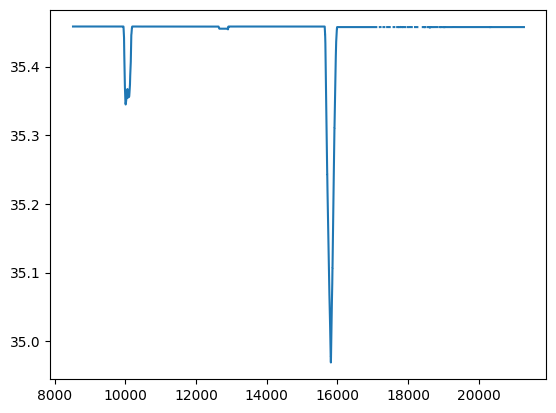

In [159]:
trip_start_idx, trip_end_idx = mgo_trips_idxs[1]
nav_fuel_df["CurrentLat"][trip_start_idx:trip_end_idx].plot()